# Analysis of the SSVEP data

Let's load a couple libraries we'll use repeatedly, and set the default plot size.

In [1]:
library(dplyr, warn.conflicts=FALSE)
library(stringr)
library(ggplot2)

options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)

# Setup / preprocessing

The dataframe we're about to load has already undergone fourier transform & projection to FSAverage cortical space, so we're dealing with vertex numbers and frequency bin amplitudes, across subject and pre/post intervention measurement times.  This assumes it's in the same folder as the notebook; adjust path as needed:

**NOTE:** at the end of this section, we save out the munged data, so you can skip these cells on later runs.

## Path management

In [2]:
file.path("..", "..", "params") -> param_dir
yaml::read_yaml(file.path(param_dir, "paths.yaml")) -> paths
paths$results_dir -> results_dir
"/data/prek/results" -> results_dir  # for running on agelaius
file.path(results_dir, "pskt", "group-level", "dataframe") -> dataframe_dir

## Load the cohort groupings and inverse parameters

In [3]:
# load intervention groups
file.path(param_dir, "intervention_cohorts.yaml") -> intervention_file
yaml::read_yaml(intervention_file) -> intervention

# load pre-test cohorts
file.path(param_dir, "letter_knowledge_cohorts.yaml") -> pretest_file
yaml::read_yaml(pretest_file) -> pretest

# load inverse constraint parameters
file.path(param_dir, "inverse_params.yaml") -> inv_constraint_file
yaml::read_yaml(inv_constraint_file) -> inv
str_c(inv$orientation_constraint, "-", inv$estimate_type) -> inv_constr

## Load and clean the brain data

In [4]:
str_c("all_subjects-fsaverage-", inv_constr, "-freq_domain-stc.csv") -> fname
file.path(dataframe_dir, fname) -> fpath
readr::cols(freq="d", value="d", .default="c") -> col_types

proc.time() -> start
readr::read_csv(fpath, col_types=col_types) -> all_data
print(proc.time() - start)

   user  system elapsed 
176.328   2.319 178.657 


Now to merge in the cohort groupings and do some light cleaning:

In [5]:
proc.time() -> start
all_data %>%
    tidyr::separate(source, c("hemi", "vertex"), sep="_") %>%
    rename(amplitude=value) %>%
    mutate(hemi=str_to_lower(hemi),
           vertex=as.integer(vertex),
           subj_num=str_sub(subject, -4),
           intervention=if_else(subj_num %in% intervention$LetterIntervention, "letter", "language"),
           pretest=if_else(subj_num %in% pretest$LowerKnowledge, "lower", "upper")) %>%
    # set column order
    select(subject, pretest, intervention, timepoint, freq, hemi, vertex, amplitude, -subj_num) ->
    all_data
print(proc.time() - start)

print(all_data)

   user  system elapsed 
205.025   8.924 213.956 
# A tibble: 247,774,464 x 8
   subject   pretest intervention timepoint  freq hemi  vertex amplitude
   <chr>     <chr>   <chr>        <chr>     <dbl> <chr>  <int>     <dbl>
 1 prek_1103 lower   language     pre           0 lh         0      81.3
 2 prek_1103 lower   language     pre           0 lh         1      31.5
 3 prek_1103 lower   language     pre           0 lh         2      44.5
 4 prek_1103 lower   language     pre           0 lh         3     134. 
 5 prek_1103 lower   language     pre           0 lh         4      56.6
 6 prek_1103 lower   language     pre           0 lh         5      29.5
 7 prek_1103 lower   language     pre           0 lh         6      60.8
 8 prek_1103 lower   language     pre           0 lh         7      75.8
 9 prek_1103 lower   language     pre           0 lh         8      69.2
10 prek_1103 lower   language     pre           0 lh         9      87.9
# … with 247,774,454 more rows


## Compute noise and SNR

Next we'll define a function that will compute noise (the mean of the two frequency bins below and two frequency bins above the current bin), and apply it within a `group_by` operation.

In [6]:
# function to compute noise (mean of 2 bins above and below; handles edges gracefully)
compute_noise <- function(x) {
    rowMeans(cbind(lag(x, 2), lag(x, 1), lead(x, 1), lead(x, 2)), na.rm=TRUE)
}

all_data %>%
    group_by(subject, timepoint, hemi, vertex) %>%
    mutate(noise=compute_noise(amplitude),
           snr=amplitude/noise) %>%
    ungroup() ->
    all_data

### Plot the frequency spectrum

Let's take a look at the average power spectrum across all vertices and subjects. The target frequencies are 2 Hz and 6 Hz, but we'll also highlight harmonics at 4, 12, and 18 Hz.

In [7]:
all_data %>%
    group_by(timepoint, freq) %>%
    summarise_at(c("amplitude", "snr"), mean) %>%
    mutate(target_freq=freq %in% c(2, 4, 6, 12, 18)) ->
    spectrum

print(spectrum)

# A tibble: 252 x 5
# Groups:   timepoint [2]
   timepoint  freq amplitude   snr target_freq
   <chr>     <dbl>     <dbl> <dbl> <lgl>      
 1 post        0       306.  1.11  FALSE      
 2 post        0.2      99.2 1.31  FALSE      
 3 post        0.4     107.  1.21  FALSE      
 4 post        0.6      62.3 0.980 FALSE      
 5 post        0.8      56.8 0.984 FALSE      
 6 post        1        61.6 1.15  FALSE      
 7 post        1.2      50.4 1.03  FALSE      
 8 post        1.4      45.2 1.03  FALSE      
 9 post        1.6      40.4 1.01  FALSE      
10 post        1.8      35.9 1.00  FALSE      
# … with 242 more rows


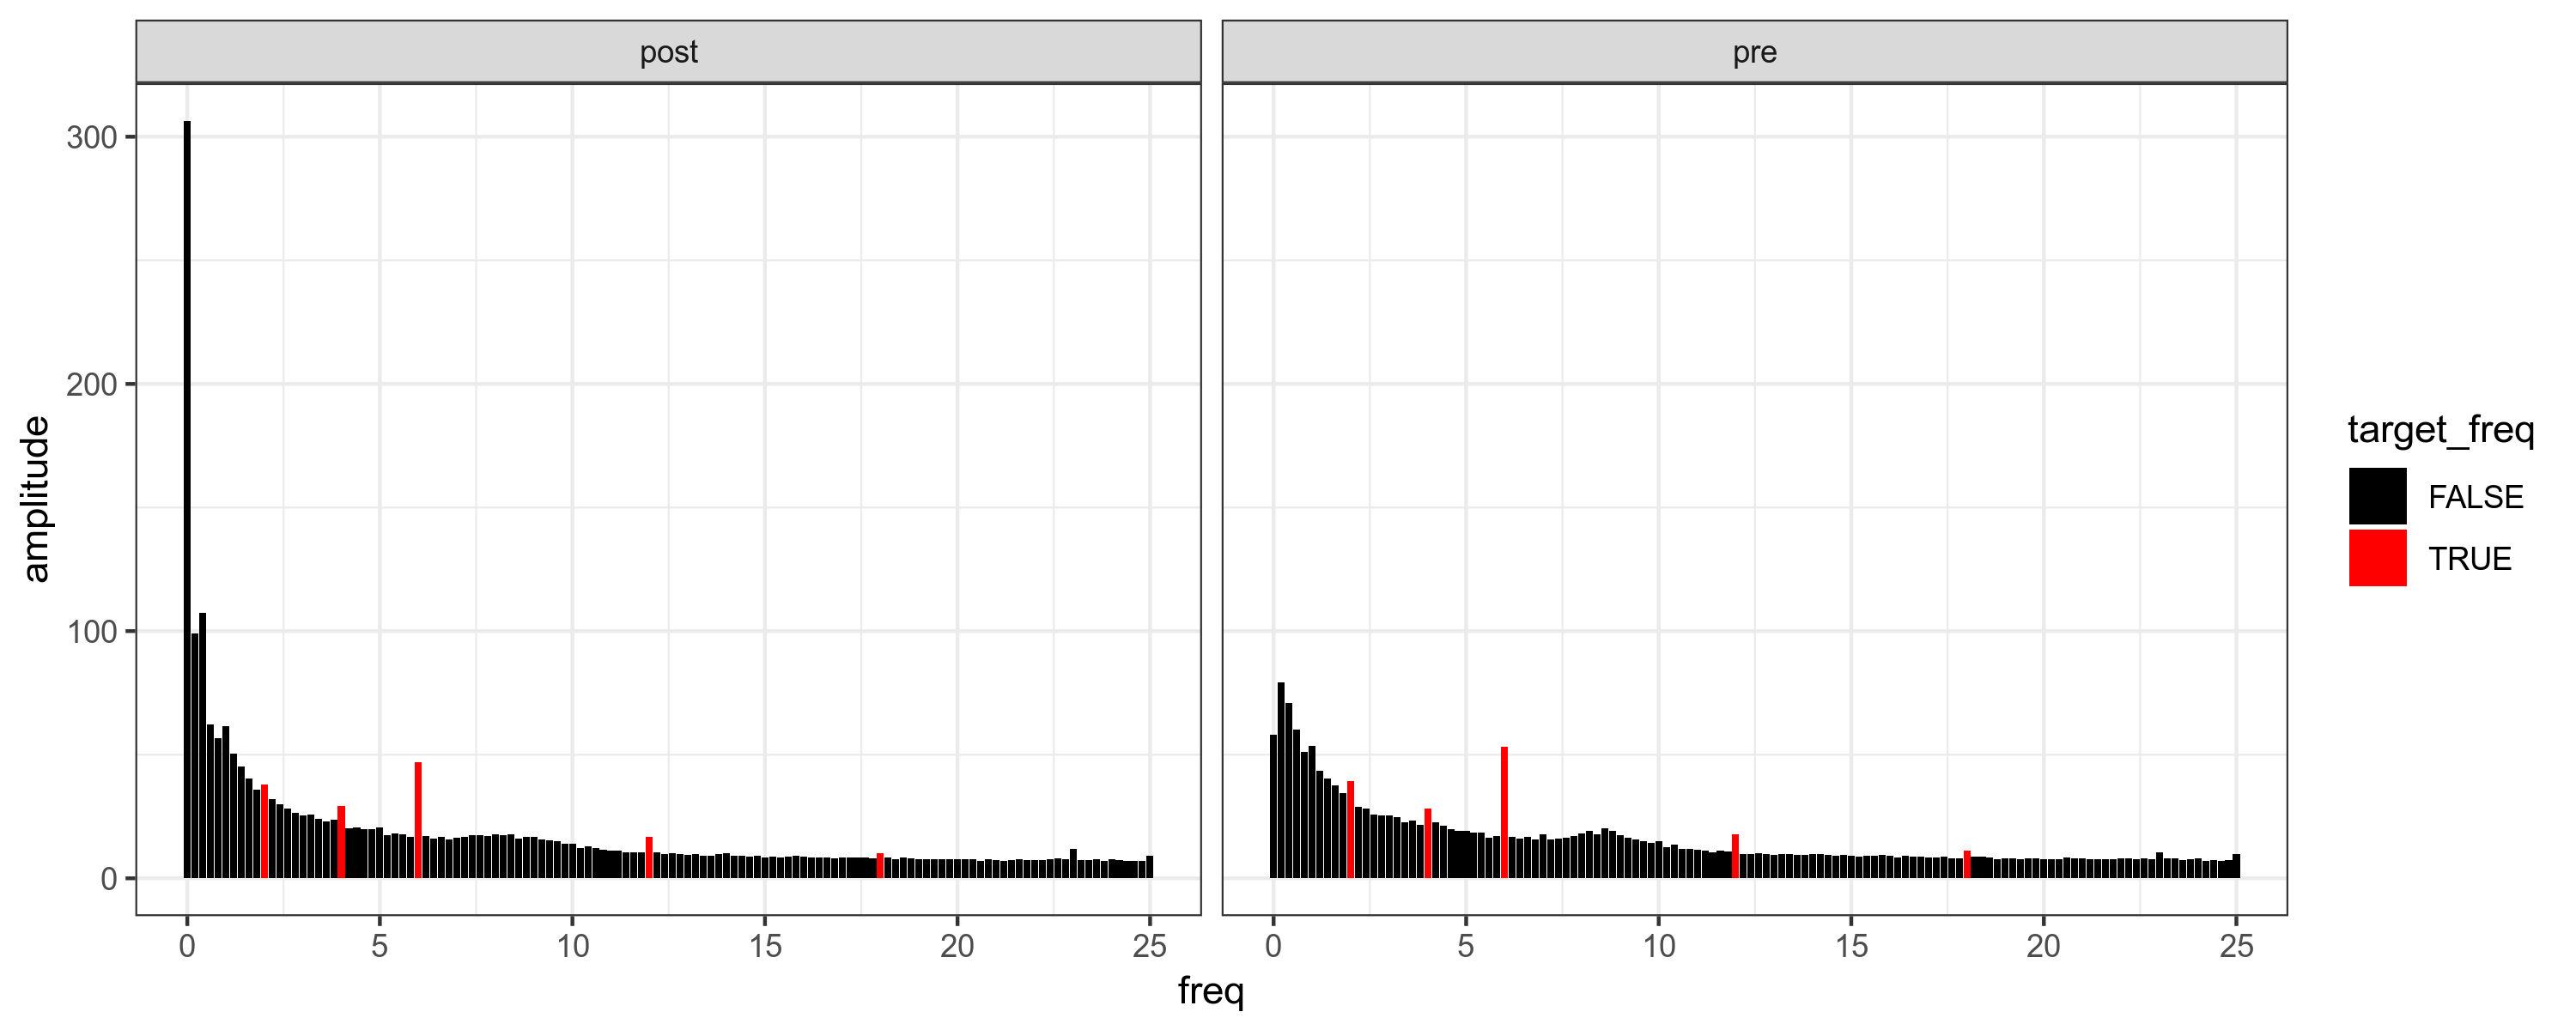

In [8]:
spectrum %>%
    ggplot(aes(x=freq, y=amplitude, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

OK, typical $\frac{1}{f}$ shape, with our target frequencies (and their harmonics) poking out. Let's flatten out the spectrum by looking at SNR instead of raw amplitude in each bin:

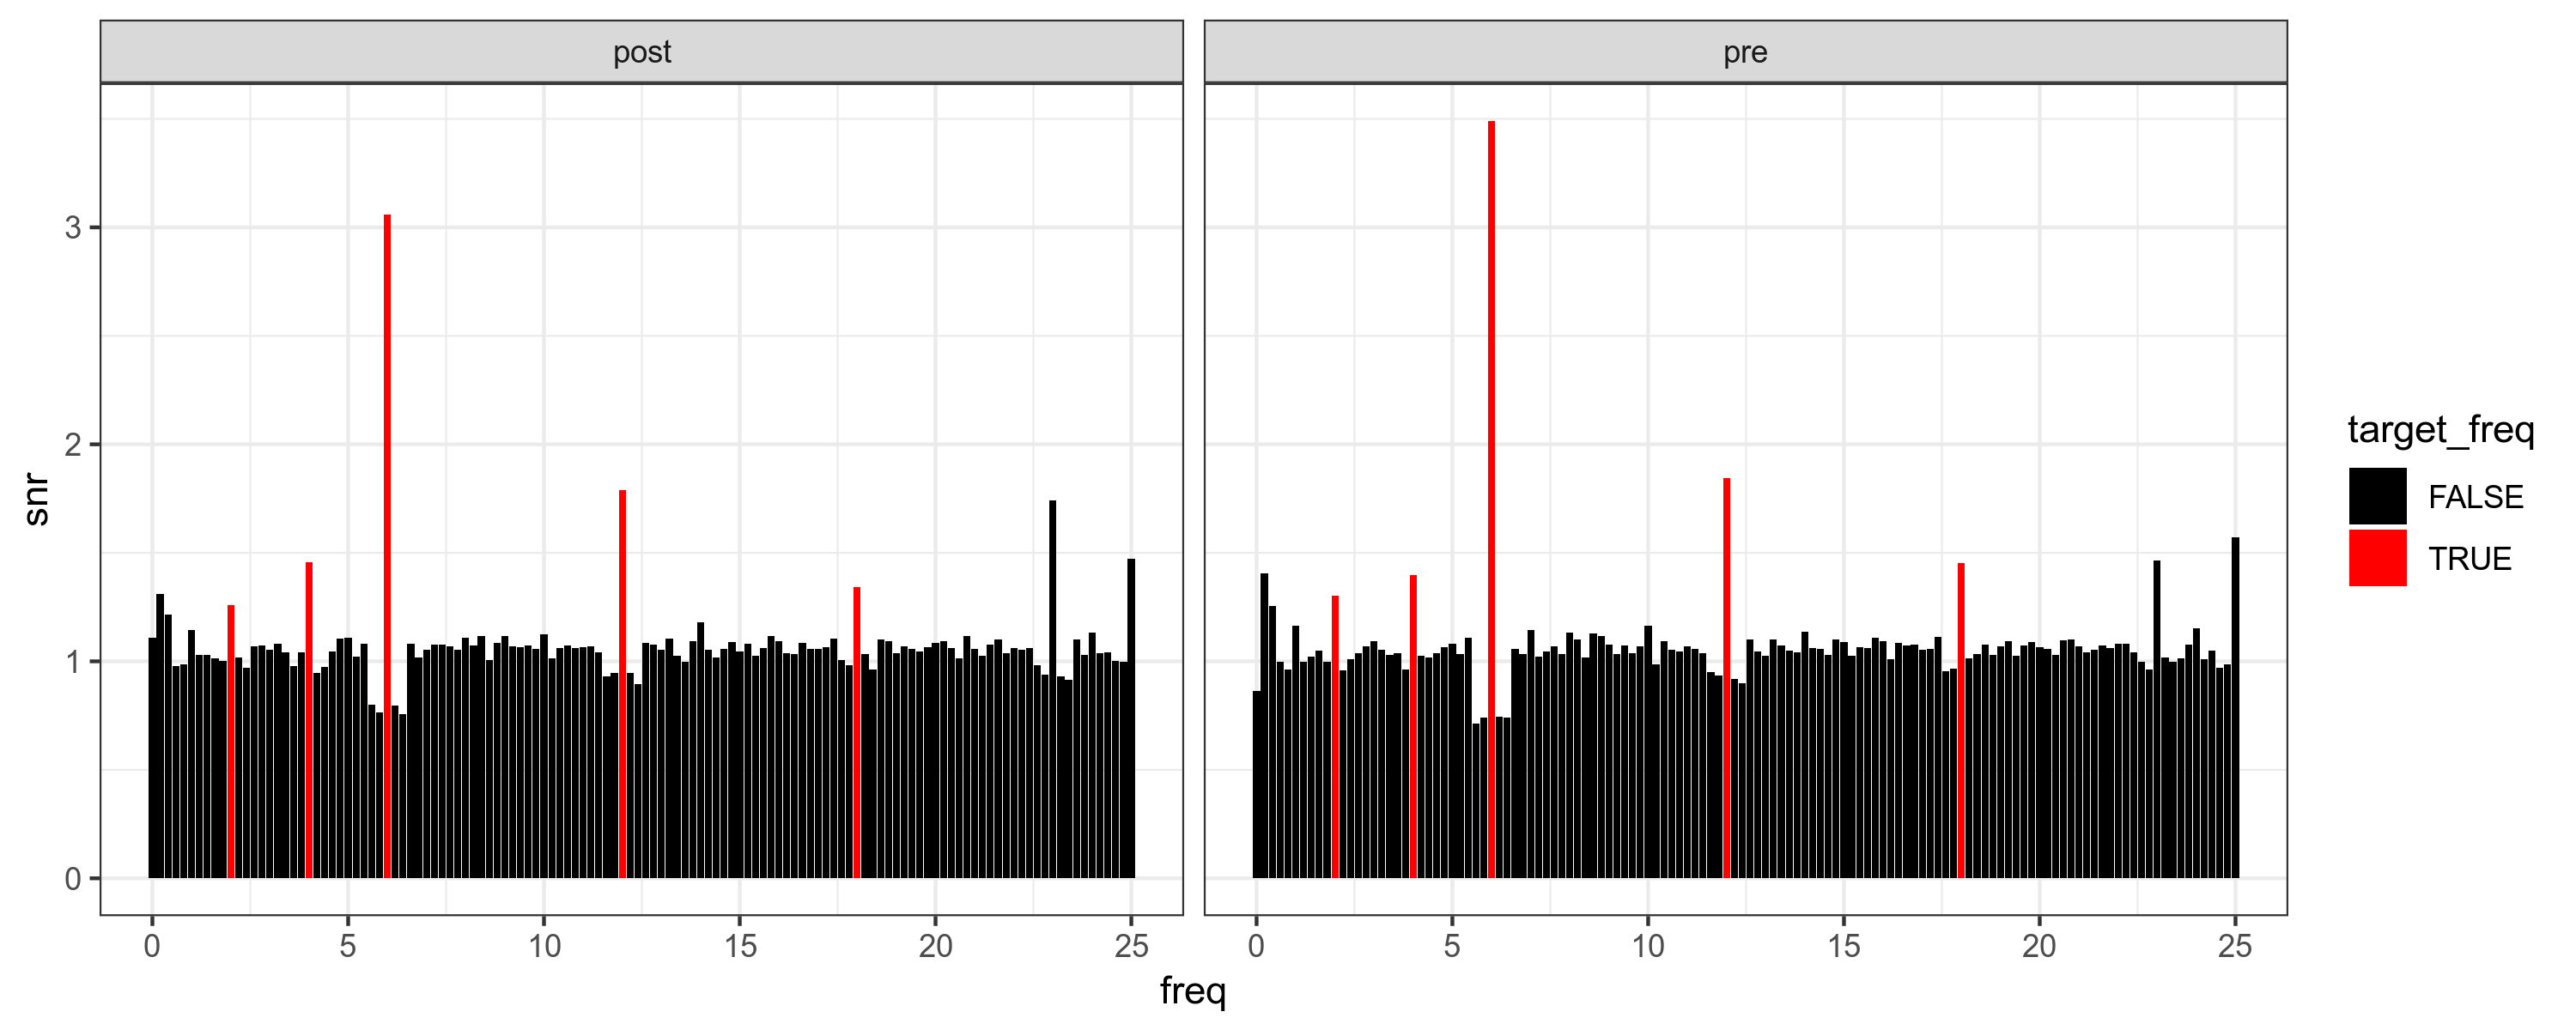

In [9]:
spectrum %>%
    ggplot(aes(x=freq, y=snr, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

That spike at 23 Hz (which is bigger in the post-intervention data) is a bit of a mystery.

## Make a tvalue-based ROI using pre-intervention 2 Hz response
Next we'll compute an uncorrected t-statistic (across subjects, at each vertex) and use it as a mask to define an ROI. The 2 Hz response is what we care most about, so let's use it to filter on t-values greater than 4, and use that as our ROI for comparing the 2 Hz response in our cohorts.

### Compute t-statistic
First we compute an (uncorrected) t-test of "signal bin" vs "mean of adjacent noise bins". This will yield a new dataframe with the t-test results.

In [10]:
# compute signal-vs-noise uncorrected t-test
all_data %>%
    filter(freq == 2, timepoint == "pre") %>%
    group_by(hemi, vertex) %>%
    do(broom::tidy(t.test(.$amplitude, .$noise, paired=TRUE))) %>%
    rename(tval=statistic, df=parameter) ->
    tvals

### Merge
Now we merge the t-values back into the main dataframe, so we can use them to filter the data. Note that these t-values were computed *across subjects* as a way of defining an ROI, so joining based only on `hemi` and `vertex` is correct here.

In [11]:
# merge t-values back into main dataframe
all_data %>%
    left_join(tvals, by=c("hemi", "vertex")) ->
    all_data

### Reduce data

Now that we have the t-values, we'll filter the data to only include our ROI vertices and the frequency we care about, and average across vertices to get a mean activation within the ROI. We'll do separate ROIs for each hemisphere.

In [12]:
all_data %>%
    filter(tval >= 4, freq == 2) %>%
    group_by(subject, timepoint, intervention, pretest, hemi) %>%
    summarise_at(c("amplitude", "noise", "snr"), mean) %>%
    ungroup() ->
    tval_roi_data

print(tval_roi_data)

# A tibble: 192 x 8
   subject   timepoint intervention pretest hemi  amplitude noise   snr
   <chr>     <chr>     <chr>        <chr>   <chr>     <dbl> <dbl> <dbl>
 1 prek_1103 post      language     lower   lh         34.6  32.8  1.06
 2 prek_1103 post      language     lower   rh         50.6  33.3  1.58
 3 prek_1103 pre       language     lower   lh         50.0  24.9  2.11
 4 prek_1103 pre       language     lower   rh         58.6  21.2  2.93
 5 prek_1110 post      language     upper   lh         33.4  19.3  1.74
 6 prek_1110 post      language     upper   rh         24.5  20.5  1.27
 7 prek_1110 pre       language     upper   lh         58.2  19.0  3.15
 8 prek_1110 pre       language     upper   rh         48.5  26.1  1.91
 9 prek_1112 post      letter       lower   lh         86.3  60.8  1.54
10 prek_1112 post      letter       lower   rh         91.1  57.7  1.76
# … with 182 more rows


Now we save the preprocessing work, so we don't have to do it every time:

In [13]:
save(tval_roi_data, file="processed_data_with_tvals.RData")

## Load SNR-based ROI labels

These are lists of vertices stored in YAML files, and are based on SNR thresholds between 1.5 (generous) and 2.5 (stringent) after pooling across all subjects and both pre- and post-camp measurements.

In [14]:
c(2, 4) -> roi_freqs
seq(1.5, 2.5, 0.1) -> snr_thresholds
list() -> snr_roi_data

for(freq_ in roi_freqs) {
    for(snr_ in snr_thresholds) {
        # load the YAML file
        str_interp("${freq_}_Hz-SNR_$[.1f]{snr_}.yaml") -> fname
        file.path("..", "ROIs", fname) -> verts_file
        yaml::read_yaml(verts_file) -> verts
        # average over vertices within this ROI label
        str_interp("${freq_}Hz_SNR_$[.1f]{snr_}") -> roi_name
        all_data %>%
            filter((vertex %in% verts$lh & hemi == "lh") | 
                   (vertex %in% verts$rh & hemi == "rh")) %>%
            group_by(subject, timepoint, intervention, pretest, hemi) %>%
            summarise_at(c("amplitude", "noise", "snr"), mean) %>%
            ungroup() ->
            snr_roi_data[[roi_name]]
    }
}

Now we save the preprocessing work, so we don't have to do it every time:

In [15]:
save(snr_roi_data, file="processed_data_with_SNR_based_labels.RData")

## Start here if skipping the preprocessing section

In [16]:
rm(all_data)  # free up memory; comment out if loading

# load("processed_data_with_tvals.RData")  # loads tval_roi_data
# load("processed_data_with_SNR_based_labels.RData")  # loads snr_roi_data

In [17]:
# combine the data from the two different ROI definitions
bind_rows(snr_roi_data, tval=tval_roi_data, .id="roi_type") ->
    roi_data

print(roi_data)

# A tibble: 3,456 x 9
   roi_type   subject timepoint intervention pretest hemi  amplitude noise   snr
   <chr>      <chr>   <chr>     <chr>        <chr>   <chr>     <dbl> <dbl> <dbl>
 1 2Hz_SNR_1… prek_1… post      language     lower   lh         16.0  16.0  1.10
 2 2Hz_SNR_1… prek_1… post      language     lower   rh         19.1  19.1  1.11
 3 2Hz_SNR_1… prek_1… pre       language     lower   lh         16.4  16.4  1.15
 4 2Hz_SNR_1… prek_1… pre       language     lower   rh         15.3  15.2  1.18
 5 2Hz_SNR_1… prek_1… post      language     upper   lh         14.0  13.9  1.10
 6 2Hz_SNR_1… prek_1… post      language     upper   rh         12.6  12.6  1.09
 7 2Hz_SNR_1… prek_1… pre       language     upper   lh         13.6  13.6  1.12
 8 2Hz_SNR_1… prek_1… pre       language     upper   rh         14.2  14.2  1.13
 9 2Hz_SNR_1… prek_1… post      letter       lower   lh         26.1  26.1  1.08
10 2Hz_SNR_1… prek_1… post      letter       lower   rh         22.4  22.4  1.09
# … wi

## Testing the main hypotheses

Now that we have our ROI data, let's test our hypotheses. We'll do it separately for each ROI definition and for each hemisphere.

### t-test of pre-intervention letter awareness

First we'll compare the two pretest groups (median split on the pre-intervention letter awareness test):

In [18]:
roi_data %>%
    filter(timepoint == "pre") %>%
    group_by(roi_type, hemi) %>%
    do(broom::tidy(t.test(amplitude ~ pretest, data=.))) %>%
    rename(tval=statistic, df=parameter) ->
    pretest_tvals

pretest_tvals

roi_type,hemi,estimate,estimate1,estimate2,tval,p.value,df,conf.low,conf.high,method,alternative
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2Hz_SNR_1.5,lh,0.10756351,15.38358,15.27601,0.10980878,0.91306263,43.79874,-1.8668520,2.081979,Welch Two Sample t-test,two.sided
2Hz_SNR_1.5,rh,1.40123178,16.24408,14.84285,1.07150748,0.29135704,34.60802,-1.2546563,4.057120,Welch Two Sample t-test,two.sided
2Hz_SNR_1.6,lh,0.18896987,15.47597,15.28700,0.18984059,0.85033199,42.77903,-1.8187725,2.196712,Welch Two Sample t-test,two.sided
2Hz_SNR_1.6,rh,1.51664455,16.36335,14.84671,1.16377489,0.25260308,34.06044,-1.1316263,4.164915,Welch Two Sample t-test,two.sided
2Hz_SNR_1.7,lh,0.22519325,15.47514,15.24995,0.22565647,0.82254502,42.70787,-1.7877573,2.238144,Welch Two Sample t-test,two.sided
2Hz_SNR_1.7,rh,1.66388862,16.49254,14.82865,1.26035440,0.21605549,34.27239,-1.0182450,4.346022,Welch Two Sample t-test,two.sided
2Hz_SNR_1.8,lh,0.26589470,15.29970,15.03380,0.28233676,0.77904857,42.72466,-1.6337081,2.165498,Welch Two Sample t-test,two.sided
2Hz_SNR_1.8,rh,1.83380116,16.56777,14.73397,1.39323645,0.17253405,34.21616,-0.8404508,4.508053,Welch Two Sample t-test,two.sided
2Hz_SNR_1.9,lh,0.09100808,14.84214,14.75113,0.11030092,0.91265779,45.31450,-1.5704882,1.752504,Welch Two Sample t-test,two.sided


### t-test of intervention effect

For the intervention effect, what we care about is *change* in activation pre-versus-post intervention, so we'll need to do a `post - pre` subtraction first:

In [19]:
roi_data %>%
    tidyr::pivot_wider(names_from=timepoint, values_from=amplitude, id_cols=c(subject, intervention, roi_type, hemi)) %>%
    mutate(post_minus_pre=post - pre) %>%
    group_by(roi_type, hemi) %>%
    do(broom::tidy(t.test(post_minus_pre ~ intervention, data=.))) %>%
    rename(tval=statistic, df=parameter) ->
    intervention_tvals

intervention_tvals

roi_type,hemi,estimate,estimate1,estimate2,tval,p.value,df,conf.low,conf.high,method,alternative
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2Hz_SNR_1.5,lh,1.5872959,2.6885038,1.10120796,0.36220144,0.72027336,24.77060,-7.442577,10.617168,Welch Two Sample t-test,two.sided
2Hz_SNR_1.5,rh,2.1592093,2.6277116,0.46850226,0.49927040,0.62207172,24.34079,-6.759985,11.078403,Welch Two Sample t-test,two.sided
2Hz_SNR_1.6,lh,1.6828372,2.7072895,1.02445231,0.37926156,0.70772510,24.77329,-7.459869,10.825544,Welch Two Sample t-test,two.sided
2Hz_SNR_1.6,rh,2.4484692,2.8656616,0.41719244,0.52652846,0.60328918,24.32751,-7.142265,12.039203,Welch Two Sample t-test,two.sided
2Hz_SNR_1.7,lh,1.6810912,2.6955263,1.01443514,0.37937318,0.70763323,24.85101,-7.447980,10.810163,Welch Two Sample t-test,two.sided
2Hz_SNR_1.7,rh,2.7254292,3.0473086,0.32187936,0.55108646,0.58660708,24.29576,-7.475126,12.925985,Welch Two Sample t-test,two.sided
2Hz_SNR_1.8,lh,1.5700592,2.5796941,1.00963494,0.37110094,0.71368400,25.03752,-7.142804,10.282923,Welch Two Sample t-test,two.sided
2Hz_SNR_1.8,rh,2.9262126,3.1441008,0.21788821,0.57190783,0.57262454,24.36053,-7.625627,13.478052,Welch Two Sample t-test,two.sided
2Hz_SNR_1.9,lh,0.9048764,1.9407507,1.03587432,0.26052788,0.79650082,26.10384,-6.233093,8.042846,Welch Two Sample t-test,two.sided


# Mixed model of intervention effect

Next let's see what the intervention effect looks like as a mixed model.

In [20]:
# create factor variables and set contrasts
dev_contrast <- function(x, ...) {
    x <- factor(x, ...)
    contrasts(x) <- contr.sum
    contrasts(x) <- contrasts(x) / 2
    colnames(contrasts(x)) <- paste0("_", levels(x)[-length(levels(x))])
    x
}

roi_data %>%
    # make predictors with sensible factor coding
    mutate(tpt=dev_contrast(timepoint, levels=c("pre", "post")),
           grp=dev_contrast(intervention, levels=c("language", "letter"))) %>%
    # pick which ROI definition to model (snr or tval)
    filter(roi_type == "tval") %>%
    # pick which hemi(s) to include
    filter(hemi %in% c("lh", "rh")) %>%
    # pick dependent measurement (amplitude or snr) as LHS of formula
    afex::mixed(amplitude ~ tpt * grp + (1|subject), data=., method="PB", REML=FALSE, check_contrasts=FALSE) ->
    model

summary(model)

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[.

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00306109 (tol = 0.002, component 1)”


.

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00302067 (tol = 0.002, component 1)”


.]


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: amplitude ~ tpt * grp + (1 | subject)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  1600.0   1619.6   -794.0   1588.0      186 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1235 -0.6117 -0.0893  0.5148  6.2020 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 103.0    10.15   
 Residual             167.9    12.96   
Number of obs: 192, groups:  subject, 48

Fixed effects:
                     Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)            45.272      1.738  48.000  26.050  < 2e-16 ***
tpt_pre                 2.267      1.870 144.000   1.212  0.22747    
grp_language            1.862      3.476  48.000   0.536  0.59464    
tpt_pre:grp_language   11.205      3.740 144.000   2.996  0.00322 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:


# More detailed regressions

Here we explore the relationship between our ROI data and the various pre-test variables / dimensions.

### Load and clean behavioral metadata

First let's load the behavioral scores. We'll clean up a few columns and drop ones we don't need.

In [21]:
# load metadata
readr::cols(event="-", group="c", visit="c", .default="i") -> col_types
readr::read_csv(file.path("..", "behavioral", "preK_InterventionData.csv"),
                col_types=col_types) %>%
    # rename/transform variables
    rename(timepoint=visit) %>%
    mutate(subject=str_c("prek_", subID),
           intervention=str_to_lower(group)) %>%
    # reorder columns and drop unwanted columns
    select(subject, timepoint, intervention, everything(), -subID, -group) ->
    metadata

print(metadata)

Warning message:
“3 parsing failures.
row               col   expected actual                                      file
 11 PhonemeSegmenting an integer    NaN '../behavioral/preK_InterventionData.csv'
 13 PhonemeSegmenting an integer    NaN '../behavioral/preK_InterventionData.csv'
 90 Retell            an integer    NaN '../behavioral/preK_InterventionData.csv'
”


# A tibble: 96 x 10
   subject timepoint intervention AlphabetKnowled… Decoding PhonemeMatching
   <chr>   <chr>     <chr>                   <int>    <int>           <int>
 1 prek_1… pre       language                   49        0               7
 2 prek_1… post      language                   59        0               8
 3 prek_1… pre       language                   90        4              12
 4 prek_1… post      language                   93        0              12
 5 prek_1… pre       letter                     23        0              12
 6 prek_1… post      letter                     36        0              14
 7 prek_1… pre       language                   31        0               7
 8 prek_1… post      language                   34        0               8
 9 prek_1… pre       language                   82        0              15
10 prek_1… post      language                   89        5               8
# … with 86 more rows, and 4 more variables: PhonemeSegmenting <int>

### Merge brain data and metadata

Now we'll join our brain data and metadata.

In [22]:
roi_data %>%
    left_join(metadata, by=c("subject", "timepoint", "intervention")) ->
    roi_data

### Sample scatterplot

Let's take a look now at the relationship between the pre-test variables and the average 2 Hz response.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



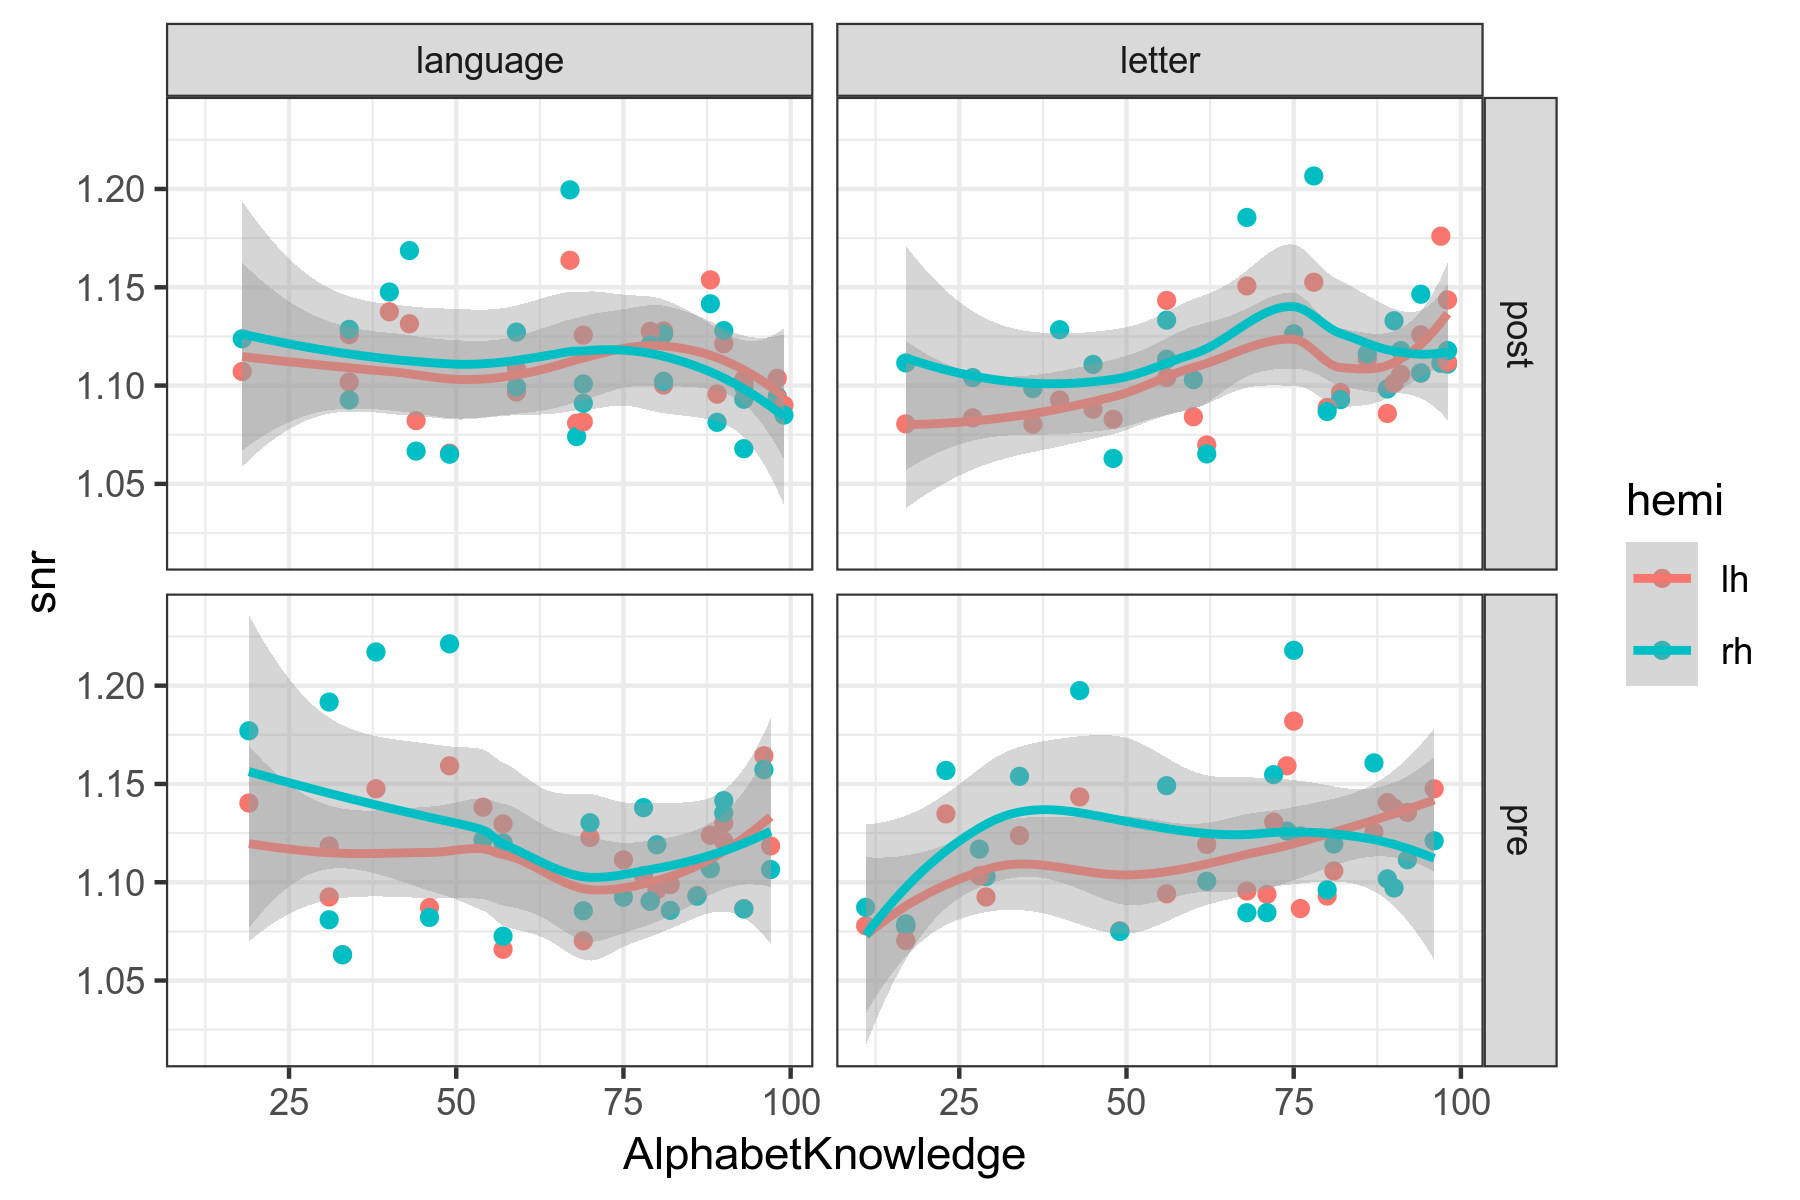

In [23]:
options(repr.plot.width=6)

roi_data %>%
    # select ROI type (tval, 2Hz_SNR_1.7, 4Hz_SNR_2.1, etc)
    filter(roi_type == "4Hz_SNR_2.0") %>%
    # select x (AlphabetKnowledge, PhonemeMatching, etc) and y (snr, amplitude)
    ggplot(aes(x=AlphabetKnowledge, y=snr, colour=hemi)) + 
    facet_grid(timepoint ~ intervention) + 
    geom_point() +
    geom_smooth() +
    theme_bw()